# IEOR4703 Monte Carlo Case Study - 2 May 2022

Chun Yat Yeung (cy2623)

# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import norm, t, gaussian_kde

In [2]:
df = pd.read_csv('20_funds.csv',index_col=0)
df.index = pd.date_range(start='12-31-2005', periods=len(df))
funds = df.columns
df.head()

,B23409,B00367,B13847,B15553,B10749,B03605,B17517,B05851,B12869,B20167,B18365,B21754,B21401,B21937,B21046,B18646,B11920,B20159,B07325,B21967
2005-12-31,12.88289,35.55018,11.50636,13.29872,25.17435,19.75900,10.44675,30.24456,10.00,246.50262,51.20245,28.29245,71.00312,13.33306,21.25487,12.79461,18.93086,156.02005,23.07846,25.53953
2006-01-01,12.88289,35.55018,11.50636,13.29872,25.17435,19.75900,10.44675,30.24456,10.00,246.50262,51.20245,28.29245,71.00312,13.33306,21.25487,12.79461,18.93086,156.02005,23.07846,25.53953
2006-01-02,12.88289,35.55018,11.50636,13.29872,25.17435,19.75900,10.44675,30.24456,10.00,246.50262,51.20245,28.29245,71.00312,13.33306,21.25487,12.79461,18.93086,156.02005,23.07846,25.53953
2006-01-03,13.08824,35.60458,11.57815,13.52239,25.56893,20.38565,10.75808,30.26963,10.16,235.42289,51.59738,28.32407,71.96846,13.52990,21.32307,12.95087,18.98386,156.34645,23.76154,26.36954
2006-01-04,13.17470,35.63178,11.58840,13.60373,25.63469,20.69897,10.89644,30.30422,10.23,234.30632,51.67636,28.32749,72.50194,13.58170,21.37990,13.02773,19.07706,155.77525,24.02989,26.80495


# Visualization

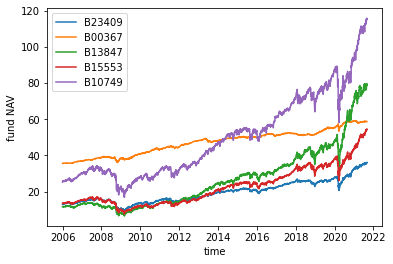

In [3]:
n = 5
for fund in funds[:n]:
    plt.plot(df[fund],label=fund)
plt.xlabel('time')
plt.ylabel('fund NAV')
plt.legend()
plt.show()

# Functions

In [4]:
def calcHistoricalReturns(df, rollingPeriod=30, timeHorizon=30, startDate=None, endDate=None):
    ''' calculate historical returns of all mutual funds '''
    if not startDate: startDate = df.index[0]
    if not endDate: endDate = df.index[-1]
    rollIdx = np.arange(0,len(df),rollingPeriod)
    dfrtn = (df.shift(-timeHorizon)-df)/df
    dfrtn = dfrtn.iloc[rollIdx].loc[startDate:endDate]
    return dfrtn

def calcVaR(dfrtn, funds=None, allocation=None, confidence=0.99, Nsim=1e5, method='bootstrap'):
    ''' calculate VaR & CVaR based on dfrtn with user-defined allocation/confidence/Nsim/method '''
    if not funds: funds = dfrtn.columns # default: all funds
    if not allocation: allocation = np.repeat(1/len(funds),len(funds)) # default: uniform
    portRtn = dfrtn[funds].dot(allocation).dropna().to_numpy() # historical portfolio returns
    out = {'funds': funds, 'allocation': allocation, 'portRtn': portRtn}
    VaR = CVaR = None
    if method == 'bootstrap':
        # the prescribed approach in instructions
        # 1. construct historical portfolio returns, via: portRtn
        # 2. bootstrap-simulate VaR & CVaR, via: varSim, cvarSim
        Nsim = int(Nsim)
        varSim = np.zeros(Nsim)
        cvarSim = np.zeros(Nsim)
        varIdx = np.ceil(len(portRtn)*(1-confidence)).astype('int')
        for i in tqdm(range(Nsim)):
            bootRtn = np.sort(np.random.choice(portRtn, len(portRtn)))
            varSim[i] = bootRtn[varIdx]
            cvarSim[i] = np.mean(bootRtn[:varIdx])
        VaR = np.mean(varSim)
        CVaR = np.mean(cvarSim)
    elif method == 'historical':
        portRtnSort = np.sort(portRtn)
        varIdx = np.floor(len(portRtn)*(1-confidence)).astype('int')
        VaR = portRtnSort[varIdx]
        CVaR = np.mean(portRtnSort[:varIdx])
    elif method == 'normal':
        portRtnMu, portRtnSig = norm.fit(portRtn)
        VaR = norm.ppf(1-confidence, loc=portRtnMu, scale=portRtnSig)
        CVaR = norm.expect(lambda x: x, loc=portRtnMu, scale=portRtnSig, ub=VaR, conditional=True)
    elif method == 't-dist':
        portRtnDf, portRtnMu, portRtnSig = t.fit(portRtn)
        VaR = t.ppf(1-confidence, portRtnDf, loc=portRtnMu, scale=portRtnSig)
        CVaR = t.expect(lambda x: x, (portRtnDf,), loc=portRtnMu, scale=portRtnSig, ub=VaR, conditional=True)
    VaR, CVaR = -VaR, -CVaR
    out.update({'VaR': VaR, 'CVaR': CVaR})
    return out

def histBootVaR(df, timeHorizon=30, lookback=None, funds=None, allocation=None, confidence=0.99, Nsim=1e5):
    ''' alternative approach to calculating VaR & CVaR, by simulating entire paths of mutual funds, known as historical bootstrap '''
    if not funds: funds = df.columns # default: all funds
    if not allocation: allocation = np.repeat(1/len(funds),len(funds)) # default: uniform
    dfrtn = (df.shift(-1)-df)/df
    dfrtn = dfrtn[funds]
    if lookback: dfrtn = dfrtn.iloc[-lookback:]
    Nsim = int(Nsim)
    portNav = np.zeros(Nsim)
    for i in tqdm(range(Nsim)):
        portNav[i] = (dfrtn.iloc[np.random.choice(len(dfrtn),timeHorizon)]+1).product().dot(allocation)
    portRtn = portNav-1
    portRtnSort = np.sort(portRtn)
    varIdx = np.floor(len(portRtn)*(1-confidence)).astype('int')
    VaR = portRtnSort[varIdx]
    CVaR = np.mean(portRtnSort[:varIdx])
    VaR, CVaR = -VaR, -CVaR
    out = {'VaR': VaR, 'CVaR': CVaR}
    return out

# Analysis

## Bootstrap portfolio returns

We follow the below steps, as prescribed in instructions:

1. calculate historical **mutual fund** returns, based on user-defined `rollingPeriod` and `timeHorizon`
2. calculate historical **portfolio** returns, constructed with specified `funds` and `allocation`
3. **bootstrap-simulate** from historical portfolio returns (the empirical distribution), which leads to `varSim` and `cvarSim`, and the means constitute **VaR** and **CVaR**

`calcVaR(dfrtn, ...)` handles this routine, and offers a few other VaR calculation methods for comparison, including `historical`, `normal` and `t-dist`.

1. `historical` directly gives VaR and CVaR from historical portfolio returns, by sorting and finding the appropriate threshold
2. `normal` assumes a Gaussian distribution for portfolio returns, matching first and second moments, and this is known to severely underestimate tail risks, with very small VaR and CVaR
3. `t-dist` assumes a Student's t-distribution for portfolio returns, with a degree of freedom calibrated to historical returns. While it produces heavy tails, it assumes symmetric distribution, which may not be realistic (loss distribution is right-skewed)

In the example below, we study calculations for `rollingPeriod=30` and `timeHorizon=30`, i.e. non-overlapping **one-month** rolling returns. First obtain `dfrtn` from `calcHistoricalReturns(df, ...)`, then pass `dfrtn` to `calcVaR(dfrtn, ...)` with a desired method. With bootstrap simulation, we obtain the one-month VaR $0.12233\%$ and CVaR $0.15118\%$. Note that these refer to portfolio **loss** over a one-month period. Roughly they have identical order of magnitude with `historical` method, but `historical` makes use of only one sample series, thus the estimated VaR and CVaR are not statistically significant. In contrast, `bootstrap` uses `Nsim` series, with estimations more stable (due to averaging over all bootstrap samples).

In [5]:
dfrtn = calcHistoricalReturns(df, 30, 30)
dfrtn.head()

,B23409,B00367,B13847,B15553,B10749,B03605,B17517,B05851,B12869,B20167,B18365,B21754,B21401,B21937,B21046,B18646,B11920,B20159,B07325,B21967
2005-12-31,0.046141,0.003443,0.015152,0.035933,0.038140,0.065411,0.055187,0.002578,0.056000,-0.128571,0.029695,6.471691e-04,0.038283,0.020202,0.054011,0.067529,0.013793,0.028766,0.060254,0.131593
2006-01-30,0.005613,0.002669,0.014048,0.006642,-0.001007,0.007442,0.005231,0.004005,0.001894,0.082367,0.008614,2.882650e-03,-0.001034,0.015993,-0.002030,-0.008274,0.011346,0.000508,0.012961,0.011300
2006-03-01,0.010367,-0.002486,0.006926,0.004399,0.009482,0.025854,0.030647,-0.006759,0.017013,-0.023642,0.003713,1.107340e-03,0.004484,0.004843,0.036096,0.031491,-0.009879,0.071138,0.036910,-0.000466
2006-03-31,0.014995,0.001925,-0.002580,0.008029,0.026566,0.039604,0.049696,-0.000390,0.015799,-0.046916,-0.010359,2.414173e-03,0.028159,0.000747,0.009323,0.005258,0.008375,0.055503,0.046511,0.074523
2006-04-30,-0.040435,0.000384,-0.023276,-0.039826,-0.029785,-0.057143,-0.044445,0.003683,-0.046661,0.056372,-0.032150,3.509704e-07,-0.029726,-0.034328,-0.057365,-0.057562,-0.017026,0.004045,-0.043991,-0.114434


In [6]:
for method in ['bootstrap','historical','normal','t-dist']:
    simOut = calcVaR(dfrtn, method=method)
    VaR, CVaR = simOut['VaR'], simOut['CVaR']
    print(f'method = {method}, VaR = {VaR}, CVaR = {CVaR}')

100%|██████████| 100000/100000 [00:02<00:00, 35924.79it/s]


method = bootstrap, VaR = 0.09459406695868117, CVaR = 0.13663232164504419
method = historical, VaR = 0.1549411556439678, CVaR = 0.16770678995134303
method = normal, VaR = 0.07019531506080463, CVaR = 0.08120307869127266
method = t-dist, VaR = 0.09625891023369396, CVaR = 0.18400253654661636


portfolio return mean = 0.005373969994835999, sd = 0.03248408627914174


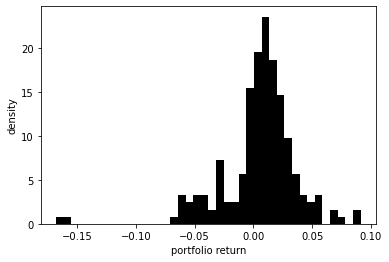

In [7]:
portRtn = simOut['portRtn']
print(f'portfolio return mean = {np.mean(portRtn)}, sd = {np.std(portRtn)}')
plt.hist(portRtn, color='k', bins=40, density=True)
plt.xlabel('portfolio return')
plt.ylabel('density')
plt.show()

### Variation of VaR with `rollingPeriod`

Here we study the variation of VaR with `rollingPeriod` $\delta$. When $\delta$ is small, returns have large overlapping window, thus more correlated, which leads to more severe VaR. Intuition: let's say there is a market crash, when we have a small $\delta$, impact of the crash persists for a longer period of time (i.e. reflected in our computed returns), thus low returns stand higher chance getting sampled, leading to large VaR. Below, we use $\delta = 10,20,...,180$ keeping `timeHorizon` fixed at $180$ (half-year). Indeed VaR and CVaR drop and stabalize with larger $\delta$, when overlapping is less.

100%|██████████| 10000/10000 [00:00<00:00, 48065.15it/s]


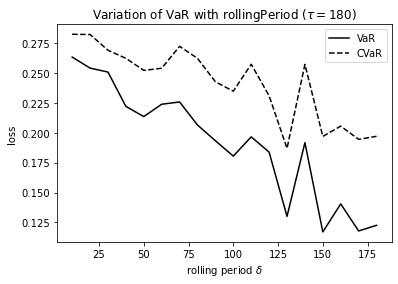

In [8]:
rollingPeriods = np.arange(10,190,10)
varList = list()
cvarList = list()
for rollingPeriod in rollingPeriods:
    dfrtn = calcHistoricalReturns(df, rollingPeriod, 180)
    simOut = calcVaR(dfrtn, method='bootstrap', Nsim=1e4)
    varList.append(simOut['VaR'])
    cvarList.append(simOut['CVaR'])
plt.plot(rollingPeriods,varList,'k',label='VaR')
plt.plot(rollingPeriods,cvarList,'k--',label='CVaR')
plt.title(r'Variation of VaR with rollingPeriod ($\tau=180$)')
plt.xlabel('rolling period $\delta$')
plt.ylabel('loss')
plt.legend()
plt.show()

### Variation of VaR with `start/endDate`

Here we study the variation of VaR with `start/endDate` $t_{s/e}$, fixing `rollingPeriod` at $7$ and `timeHorizon` at $7$, i.e. non-overlapping weekly returns. The routine offers flexibility for user to choose different start and end dates, to inspect periods of interest. Historical returns between `startDate` and `endDate`, spanning one year, are fed into VaR routine and we examine the VaR time series. As expected, during financial crisis in 2008, assets do not perform well, which is reflected in the spike in VaR and CVaR; while during the market boom starting 2010 onwards, VaR has relatively low values, of the order $3\%$.

100%|██████████| 10000/10000 [00:00<00:00, 46566.90it/s]


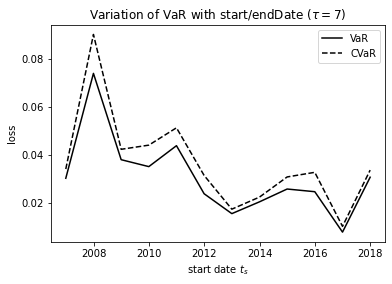

In [9]:
N = 12
T0 = pd.date_range(start='01-01-2006', periods=N, freq='1Y')
T1 = T0 + pd.DateOffset(years=1)
varList = list()
cvarList = list()
for i in range(N):
    dfrtn = calcHistoricalReturns(df, 7, 7, T0[i], T1[i])
    simOut = calcVaR(dfrtn, method='bootstrap', Nsim=1e4)
    varList.append(simOut['VaR'])
    cvarList.append(simOut['CVaR'])
plt.plot(T0,varList,'k',label='VaR')
plt.plot(T0,cvarList,'k--',label='CVaR')
plt.title(r'Variation of VaR with start/endDate ($\tau=7$)')
plt.xlabel('start date $t_s$')
plt.ylabel('loss')
plt.legend()
plt.show()

## Bootstrap mutual fund paths

Here we follow a different bootstrap approach, known as **historical bootstrap**, more commonly used in risk management:

1. bootstrap from historical **daily** mutual fund returns to simulate portfolio NAV over the next `timeHorizon`
2. repeat bootstrap procedure for `Nsim` scenarios, from which VaR and CVaR are calculated

The difference with previous approach is, we simulate entire paths of mutual funds, day by day, for a future `timeHorizon`, and then we have a collection of future scenarios from which VaR and CVaR can be estimated. `histBootVaR(df, ...)` handles this routine. As very old data may be less relavent, parameter `lookback` is included, for example, `lookback=90` uses only the most recent 90 days of data for bootstrap.

Below we study calculations bootstrapping from the entire historical timeframe and recent 90 days. As recent 90 days do not involve extreme market crash, VaR and CVaR for `lookback=90` is smaller, by roughly a half. Compared with the previous approach (bootstrap portfolio returns), this approach gives smaller VaR estimates, as we are simulating day by day, and daily gains and losses even out, leading to small VaR.

In [10]:
simOut = histBootVaR(df, 30)
VaR, CVaR = simOut['VaR'], simOut['CVaR']
print(f'method = historical bootstrap, VaR = {VaR}, CVaR = {CVaR}')

100%|██████████| 100000/100000 [00:39<00:00, 2550.01it/s]

method = historical bootstrap, VaR = 0.07972623738332185, CVaR = 0.09354835204704694


In [11]:
simOut = histBootVaR(df, 30, lookback=90)
VaR, CVaR = simOut['VaR'], simOut['CVaR']
print(f'method = historical bootstrap, VaR = {VaR}, CVaR = {CVaR}')

100%|██████████| 100000/100000 [00:39<00:00, 2562.45it/s]

method = historical bootstrap, VaR = 0.03634564642711302, CVaR = 0.04262776968178128
